Jordi Auñon Ansio 1636172  
Sistemes de Visió per Computador 2025

<div align="center" style="text-align: center; font-size: 30px;">
   <strong>Pràctica 1 Sistemes de Visió per Computador</strong>
</div>


In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


<div style="font-size: 18px;">
   <strong>2.1 Repte 1: Descarregar i visualitzar les imatges a processar</strong>
</div>


In [23]:
def align_photos(dir1_path, dir2_path):
    dir1_files = sorted(os.listdir(dir1_path))
    dir2_files = sorted(os.listdir(dir2_path))

    fig, axes = plt.subplots(len(dir1_files), 2, figsize=(7, len(dir1_files) * 3))  # Adjust size dynamically

    for i, (img1, img2) in enumerate(zip(dir1_files, dir2_files)):
        if img1 == img2:
            original_path = os.path.join(dir1_path, img1)
            raw_path = os.path.join(dir2_path, img2)

            original = cv2.imread(original_path)
            raw = cv2.imread(raw_path)

            if original is None or raw is None:
                print(f"Error loading {img1} or {img2}")
                continue

            # Convert BGR (OpenCV format) to RGB (Matplotlib format)
            original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

            # Display images
            axes[i, 0].imshow(original)
            axes[i, 0].set_title(f"Original: {img1}")

            axes[i, 1].imshow(raw)
            axes[i, 1].set_title(f"RAW: {img2}")

    plt.tight_layout()
    plt.show()


In [ ]:
align_photos("images/Original", "images/Raw")

<div style="font-size: 18px;">
   <strong>2.2 Repte 2: Mostra el patró de Bayer de im00.png de manera acolorida</strong>
</div>


In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def raw_to_rgb(raw_img):
    """
    Converteix una imatge RAW d'un sol canal en una imatge RGB reorganitzada.
    
    Arguments:
    raw_img -- Imatge d'un sol canal (numpy array 2D)

    Retorna:
    rgb_img -- Imatge RGB amb els píxels distribuïts correctament (numpy array 3D)
    """
    # Verificar que la imatge d'entrada sigui en escala de grisos
    if len(raw_img.shape) != 2:
        raise ValueError("La imatge RAW ha de tenir un sol canal (escala de grisos).")
    
    # Obtenir la mida de la imatge
    h, w = raw_img.shape

    # Crear una imatge RGB inicialitzada a zeros
    rgb_img = np.zeros((h, w, 3), dtype=np.uint8)

    # Assignar valors als canals R, G, B basant-se en la posició dels píxels
    rgb_img[0::2, 0::2, 2] = raw_img[0::2, 0::2]  # Canal Vermell (R)
    rgb_img[1::2, 0::2, 1] = raw_img[1::2, 0::2]  # Canal Verd (G) (files imparells, columnes parells)
    rgb_img[0::2, 1::2, 1] = raw_img[0::2, 1::2]  # Canal Verd (G) (files parells, columnes imparells)
    rgb_img[1::2, 1::2, 0] = raw_img[1::2, 1::2]  # Canal Blau (B)

    # Mostrar les imatges amb Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    axes[0].imshow(raw_img, cmap="gray")
    axes[0].set_title("Imatge RAW (1 Canal)")

    # Mostrar imatge RGB
    axes[1].imshow(rgb_img)
    axes[1].set_title("Imatge RGB Reconstruïda")

    plt.tight_layout()
    plt.show()

    return rgb_img

In [ ]:

raw_img = cv2.imread("images/Raw/im00.png", cv2.IMREAD_GRAYSCALE)
rgb_img = raw_to_rgb(raw_img)

<div style="font-size: 18px;">
   <strong>2.3 Repte 3: Demosaicing basat en el veí més proper</strong>
</div>


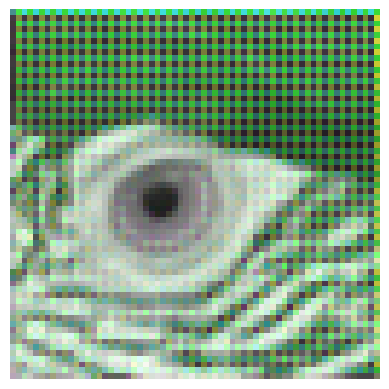

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def demosaic_nearest_neighbor(raw_image):
    """
    Aplica demosaicing a una imagen RAW en patrón RGGB usando el método del vecino más próximo.
    
    Parámetros:
        raw_image (numpy.ndarray): Matriz 2D representando la imagen RAW (Bayer RGGB).
    
    Retorna:
        numpy.ndarray: Imagen RGB reconstruida (3 canales).
    """
    # Dimensiones de la imagen
    h, w = raw_image.shape
    
    # Crear una imagen RGB vacía
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Recorrer cada píxel y asignar valores según el patrón RGGB
    for i in range(h):
        for j in range(w):
            if (i % 2 == 0 and j % 2 == 0):  # Píxel Rojo (R)
                rgb_image[i, j, 0] = raw_image[i, j]  # R
                rgb_image[i, j, 1] = get_nearest(raw_image, i, j, h, w)  # G
                rgb_image[i, j, 2] = get_nearest(raw_image, i, j, h, w)  # B

            elif (i % 2 == 0 and j % 2 == 1):  # Píxel Verde (G) en fila par
                rgb_image[i, j, 0] = get_nearest(raw_image, i, j, h, w)  # R
                rgb_image[i, j, 1] = raw_image[i, j]  # G
                rgb_image[i, j, 2] = get_nearest(raw_image, i, j, h, w)  # B

            elif (i % 2 == 1 and j % 2 == 0):  # Píxel Verde (G) en fila impar
                rgb_image[i, j, 0] = get_nearest(raw_image, i, j, h, w)  # R
                rgb_image[i, j, 1] = raw_image[i, j]  # G
                rgb_image[i, j, 2] = get_nearest(raw_image, i, j, h, w)  # B

            else:  # Píxel Azul (B)
                rgb_image[i, j, 0] = get_nearest(raw_image, i, j, h, w)  # R
                rgb_image[i, j, 1] = get_nearest(raw_image, i, j, h, w)  # G
                rgb_image[i, j, 2] = raw_image[i, j]  # B

    return rgb_image

def get_nearest(image, i, j, h, w):
    """
    Obtiene el valor del vecino más próximo para completar la información en un canal faltante.
    
    Parámetros:
        image (numpy.ndarray): Imagen RAW 2D.
        i, j (int): Coordenadas del píxel.
        h, w (int): Dimensiones de la imagen.
    
    Retorna:
        int: Valor del vecino más próximo.
    """
    # Lista de posibles vecinos (arriba, abajo, izquierda, derecha)
    vecinos = []
    
    if i > 0: vecinos.append(image[i - 1, j])  # Arriba
    if i < h - 1: vecinos.append(image[i + 1, j])  # Abajo
    if j > 0: vecinos.append(image[i, j - 1])  # Izquierda
    if j < w - 1: vecinos.append(image[i, j + 1])  # Derecha

    # Devolver el valor más cercano disponible
    return int(np.median(vecinos))

# --- Ejemplo de uso ---
# Cargar una imagen RAW simulada (debes reemplazar esto con tu imagen real)
img = Image.open("images/Raw/im00.png")
raw_image = np.array(img)

# Aplicar demosaicing
rgb_image = demosaic_nearest_neighbor(raw_image)

# Mostrar la imagen resultante
plt.imshow(rgb_image)
plt.axis("off")
plt.show()
